In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

import get_spectra

### load crossmatch

In [2]:
xmatch = Table.read("../cats/apogee-dr-15-lamost-dr-4v2.fits")
xmatch = xmatch[xmatch["SNR"] > 300]
xmatch = xmatch[xmatch["snrz"] > 300]
xmatch = xmatch[np.logical_and(xmatch["COMMISS"] == 0, xmatch["STARFLAG"] != 1)] #hacks, hacks, hacks
len(xmatch)

3591

### download APOGEE spectra

In [95]:
get_spectra.download_apogee_spectra(xmatch)
flux, err = get_spectra.load_apogee_spectrum(xmatch[1])
npix1 = flux.shape[0]

of 3591 spectra, 0 need to be downloaded


### download LAMOST spectra

In [96]:
importlib.reload(get_spectra)
get_spectra.download_lamost_spectra(xmatch["obsid"])
lamost_wl, flux, ivar = get_spectra.load_lamost_spectrum(xmatch["obsid"][0])
npix2 = flux.shape[0]

of 3591 spectra, 0 need to be downloaded


### organize data

In [165]:
nstar = len(xmatch)
F1 = torch.empty(npix1, nstar)
E1 = torch.empty(npix1, nstar) 
F2 = torch.empty(npix2, nstar)
E2 = torch.empty(npix2, nstar) 
for i, row in enumerate(xmatch):
    flux, err = get_spectra.load_apogee_spectrum(row)
    F1[:, i] = torch.from_numpy(flux.byteswap().newbyteorder())
    E1[:, i] = torch.from_numpy(err.byteswap().newbyteorder())
    
    _, flux, err = get_spectra.load_lamost_spectrum(row['obsid'])
    F2[:, i] = torch.from_numpy(flux)
    E2[:, i] = torch.from_numpy(np.power(err, -0.5))
    
F2[torch.isnan(F2)] = 0.0
E2[torch.isnan(E2)] = 100.
E2[F2 == float("inf")] = float("inf")
F2[F2 == float("inf")] = 0.0

F1_all = F1
E1_all = E1
F2_all = F2
E2_all = E2

RuntimeError: The expanded size of the tensor (7514) must match the existing size (8575) at non-singleton dimension 0.  Target sizes: [7514].  Tensor sizes: [8575]

In [443]:
label_names = ["TEFF_1", "LOGG_1", "FE_H", "O_FE"]
label_err_names = ["TEFF_ERR_1", "LOGG_ERR_1", "FE_H_ERR", "O_FE_ERR"]
nlab = len(label_names)
labels = torch.empty(nlab, nstar)
label_err = torch.empty(nlab, nstar)
for i, (ln, en) in enumerate(zip(label_names, label_err_names)):
    labels[i, :] = torch.from_numpy(xmatch[ln].data.byteswap().newbyteorder())
    label_err[i, :] = torch.from_numpy(xmatch[en].data.byteswap().newbyteorder())
    
F1 = F1_all
E1 = E1_all
F2 = F2_all
E2 = E2_all

In [444]:
#labels present, no missing pixels in F1, * APOGEE spectrum not messed up
mask = (~torch.any(labels == -9999, 0)) * (torch.sum(F1 == 0., dim=0)-1061 == 0) \
        * torch.tensor(xmatch["ASPCAPFLAG"] == 0) * torch.tensor(xmatch["STARFLAG"] == 0)
F1 = F1[:, mask]
E1 = E1[:, mask]
F2 = F2[:, mask]
E2 = E2[:, mask]
labels = labels[:, mask]
label_err = label_err[:, mask]
nstars = torch.sum(mask).item()
print(nstars)

1139


In [445]:
#remove 0'ed pixels
mask = ~(F1[:, 1] == 0.) 
F1 = F1[mask, :]
E1 = E1[mask, :]
npix1 = F1.shape[0]

In [446]:
pivot = torch.mean(labels, dim=1).reshape([-1,1])
scatter = torch.std(labels, dim=1).reshape([-1,1])
labels = (labels-pivot)/scatter
label_err /= scatter

In [447]:
#remove chemical outliers, messed-up APOGEE spectra
mask = ~torch.any(torch.abs(labels) > 3, dim=0) 
F1 = F1[:, mask]
E1 = E1[:, mask]
F2 = F2[:, mask]
E2 = E2[:, mask]
labels = labels[:, mask]
label_err = label_err[:, mask]
nstars = torch.sum(mask).item()
print(nstars)

1109


In [448]:
#impute cosmic rays
F1[(E1 > 1)] = 1.0

### define model

In [1205]:
def calc_z(F1, βz):
    return torch.matmul(F1.transpose(0,1), βz)

def calc_mu_F2(z, βF, bF):
    return (torch.matmul(z, βF) + bF).transpose(0,1)

def calc_mu_l(z, βl, bl):
    return (torch.matmul(z, βl) + bl).transpose(0,1)

def log_prior(βz, βF, bF, βl, bl):
    return -0.5 * (torch.sum(βz**2) + torch.sum(βF**2) + torch.sum(bF**2) + torch.sum(βl**2) + torch.sum(bl**2))

def log_joint(F1, F2, E2, l, el, βz, βF, bF, βl, bl): 
    lj  = 0.0
    #priors on latent variables
    lj += log_prior(βz, βF, bF, βl, bl)
    
    #likelihood
    z = calc_z(F1, βz)
    mu_F2 = calc_mu_F2(z, βF, bF)
    lj -= 0.5*torch.sum(((F2 - mu_F2)/E2)**2)
    
    mu_l = calc_mu_l(z, βl, bl)
    lll = -0.5*torch.sum(((l - mu_l)/el)**2)
    lj += lll
    
    return lj, lll

In [1206]:
homask = (torch.FloatTensor(nstars).uniform_() < 0.2)
homask[0:4] = torch.tensor([False, True, False, True])

In [1380]:
homask[2] = True

In [1214]:
def train_linear(homask, c=3, epochs=20000, batch_prob=0.10):
    βz = torch.randn(npix1, c).requires_grad_(True)
    βF = torch.randn(c, npix2).div_(c).requires_grad_(True)
    bF = torch.randn(npix2).requires_grad_(True)
    βl = torch.randn(c, nlab).div_(c).requires_grad_(True)
    bl = torch.randn(nlab).requires_grad_(True)

    holjs = []
    hollls = []
    ljs = []
    llls = []
    #with torch.autograd.detect_anomaly():
    optimizer = optim.AdamW([βz, βF, bF, βl, bl])
    for epoch in range(epochs):
        if (epoch % 100 == 0) or (epoch == epochs):
            print(f"{epoch}, ", end='')
            lj, lll = log_joint(F1[:, homask], F2[:, homask], E2[:, homask], labels[:, homask], 
                                label_err[:, homask], βz, βF, bF, βl, bl)
            holjs.append(lj.item())
            hollls.append(lll.item())
        else:
            holjs.append(holjs[-1])
        optimizer.zero_grad()
        mask = (torch.FloatTensor(nstars).uniform_() < batch_prob) * (~homask)
        lj, lll = log_joint(F1[:, mask], F2[:, mask], E2[:, mask], labels[:, mask], label_err[:, mask], βz, βF, bF, βl, bl)
        ljs.append(lj.item())
        llls.append(lll.item())
        (-lj).backward()
        if (epoch > 100) and (ljs[-1]/50 < ljs[-2]):
            z = calc_z(F1, βz)
            mu_F2 = calc_mu_F2(z, βF, bF)
            print(torch.sum(((F2 - mu_F2)/E2)**2, dim=0).shape)
            print(torch.argmax(torch.sum(((F2 - mu_F2)/E2)**2, dim=0)))
            mu_l = calc_mu_l(z, βl, bl)
            print(torch.argmax(torch.sum(((labels - mu_l)/label_err)**2, dim=0)))
            print()
        optimizer.step()

    return βz.detach(), βF.detach(), bF.detach(), βl.detach(), bl.detach(), ljs, llls, holjs, hollls

In [1215]:
outcome = dict()
for c in [2, 4, 6, 8, 10]:
    outcome[c] = train_linear(homask, c=c)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800,

In [1382]:
for c in [20]:
    outcome[c] = train_linear(homask, c=c)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800,

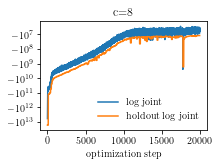

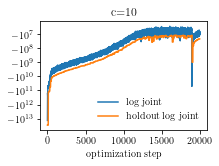

In [1283]:
cs = list(outcome.keys())
cs.sort()
for c in [8, 10]:# cs:
    βz, βF, bF, βl, bl, ljs, llls, holjs, hollls = outcome[c]
    hollls = -np.array([l for l in hollls for i in range(100)])
    llls = -np.array(llls)

    plt.figure(figsize=(3, 2))
    plt.plot(range(len(ljs)), np.array(ljs) - llls, label="log joint")
    #plt.plot(range(len(llls)),llls, label="log label likelihood")
    plt.plot(range(len(ljs)), holjs, label="holdout log joint")
    #plt.plot(range(len(hollls)), hollls, label="holdout log label likelihood")
    plt.yscale("symlog")
    plt.legend()
    plt.xlabel("optimization step")
    plt.title(f"c={c}")
    #plt.savefig(f"report/c{c}.pdf", rasterized=True)

IndexError: index 9 is out of bounds for axis 0 with size 4

<Figure size 864x432 with 0 Axes>

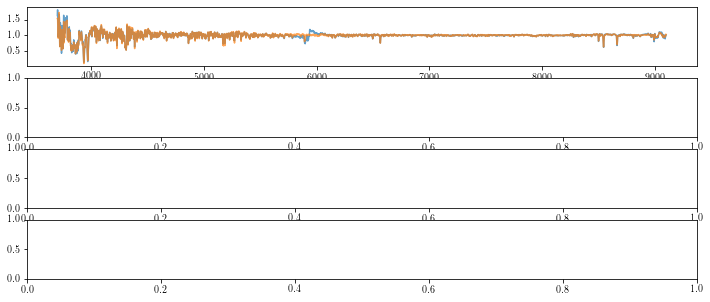

In [1410]:
c = 10
βz, βF, bF, βl, bl, ljs, llls, holjs, hollls = outcome[c]
pF2 = calc_mu_F2(calc_z(F1, βz), βF, bF).detach()

plt.figure(figsize=(12, 6))
axs = plt.subplots(4, 1, figsize=(12, 5))[1]
for j, ii in enumerate([0, 9, 13, 26]):
    i = torch.where(homask)[0][j]

    res = np.linalg.lstsq(βF.transpose(0, 1).detach().numpy(), (F2[:, i] - bF).detach().numpy(), rcond=None)
    ldpF2 = (torch.matmul(βF.transpose(0,1), torch.tensor(res[0])) + bF).detach()

    plt.sca(axs[ii])
    plt.plot(lamost_wl, F2[:, i].numpy(), alpha=0.7)
    plt.plot(lamost_wl, ldpF2.numpy(), alpha=0.7)
    
plt.xlabel("wavelength [\AA]")
plt.tight_layout()


<Figure size 288x216 with 0 Axes>

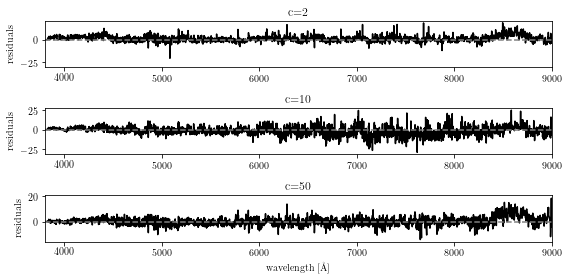

In [1414]:
plt.figure(figsize=(4, 3))
axs = plt.subplots(3, 1, figsize=(8, 4))[1]

for ii, c in enumerate([2, 10, 50]):
    plt.sca(axs[ii])
    
    βz, βF, bF, βl, bl, ljs, llls, holjs, hollls = outcome[c]
    
    pF2 = calc_mu_F2(calc_z(F1, βz), βF, bF).detach()

    j = 1
    i = torch.where(homask)[0][j]

    res = np.linalg.lstsq(βF.transpose(0, 1).detach().numpy(), (F2[:, i] - bF).detach().numpy(), rcond=None)
    ldpF2 = (torch.matmul(βF.transpose(0,1), torch.tensor(res[0])) + bF).detach()

    plt.plot(lamost_wl, ((ldpF2-F2[:, i])/E2[:, i]).numpy(), c="k", zorder=0)
    plt.title(f"c={c}")
    plt.axhline(0.0, ls="--", c="grey", zorder=1)
    plt.xlim(3800,9000)
    #plt.ylim(-10, 10)
    plt.ylabel("residuals")
plt.xlabel("wavelength [\AA]")
plt.tight_layout()
plt.savefig("report/residuals.pdf")

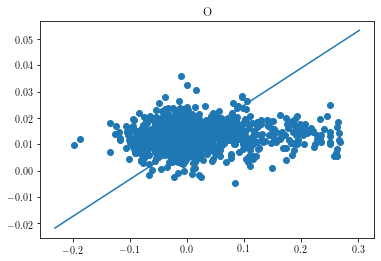

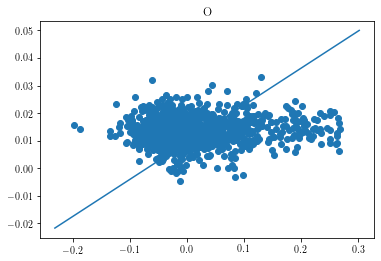

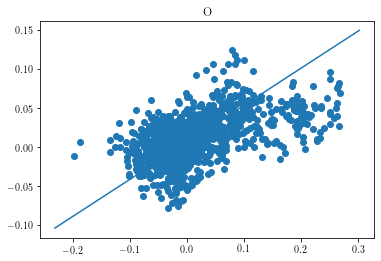

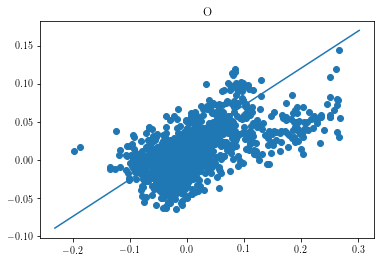

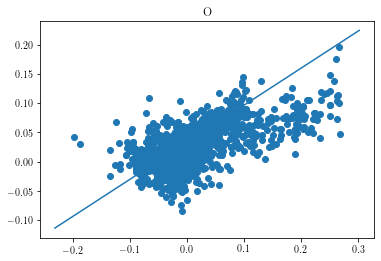

In [1221]:
for c in cs:
    βz, βF, bF, βl, bl, ljs, llls, holjs, hollls = outcome[c]
    
    plt.figure()
    mu_z = calc_z(F1, βz)#, bz)
    pl = calc_mu_l(mu_z,βl, bl)

    i = 3
    plt.title(label_names[i].split("_")[0])
    plt.scatter((labels*scatter + pivot)[i, :], (pl*scatter + pivot)[i, :].detach().numpy())
    plt.plot([*plt.xlim()], [*plt.ylim()])

    #plt.figure()
    #plt.plot(calc_z(F1, βz).detach().numpy());

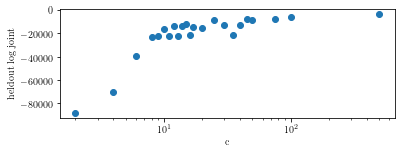

In [1295]:
plt.figure(figsize=(6, 2))
#plt.scatter(cs, [np.median(outcome[c][8][150:]) if c > 4 else outcome[c][8][-1] for c in cs])
plt.scatter(cs, [np.median(outcome[c][8][-1]) if c > 4 else outcome[c][8][-1] for c in cs])
plt.xscale("log")
plt.xlabel("c")
plt.ylabel("heldout log joint")
plt.savefig("report/cs.pdf")

# now, try to infer teffs from $z$

In [556]:
trrange = range(500,1000)
teffs = labels[0, trrange]
teffs = (teffs - torch.mean(teffs))/torch.std(teffs)

z = calc_z(F1[:, trrange], βz, bz)
res = np.linalg.lstsq(z.detach().numpy(), teffs, rcond=None)
β = res[0]

inferred_teffs = np.matmul(z.detach().numpy(), β)
plt.scatter(teffs, inferred_teffs)

torch.std(teffs-torch.tensor(inferred_teffs))

TypeError: calc_z() takes 2 positional arguments but 3 were given

### get fancy

In [1002]:
muF1    = torch.mean(F1, dim=1).reshape([-1, 1])
sigmaF1 = torch.std(F1, dim=1).reshape([-1, 1])
pF1 = ((F1 - muF1)/sigmaF1).transpose(0,1)
muF2    = torch.mean(F2, dim=1).reshape([-1, 1])
sigmaF2 = torch.std(F2, dim=1).reshape([-1, 1])
pF2 = ((F2 - muF2)/sigmaF2).transpose(0,1)
pE2 = (E2/sigmaF2).transpose(0,1)

In [1100]:
class Net(nn.Module):
    def __init__(self, len1, len2, k=30):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len1, k)
        self.fc2 = nn.Linear(k, k)
        self.fc3 = nn.Linear(k, len2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [1254]:
def log_joint_nn(F1, F2, E2, l, el, encoder, decoder, labeler):
    lj = 0.0
    for param in [*encoder.parameters()] +  [*decoder.parameters()] + [*labeler.parameters()]:
        lj -= 0.5 * torch.sum(param**2)
    z = encoder(F1)
    lj -= 0.5 * torch.sum(((decoder(z) - F2)/E2)**2)
    lll = -0.5 * torch.sum(((labeler(z).transpose(0,1) - l)/el)**2)
    lj += lll
    return lj, lll

In [1255]:
c = 40
encoder = Net(npix1, c, k=100)
decoder = Net(c, npix2, k=100)
labeler = Net(c, len(label_names), k=100)

batch_prob=0.15
epochs = 6000
holjs = []
hollls = []
ljs = []
llls = []
optimizer = optim.AdamW([*encoder.parameters()] +  [*decoder.parameters()] + [*labeler.parameters()], lr=1e-3)
for epoch in range(epochs):
    if (epoch % 100 == 0) or (epoch == epochs):
        print(f"{epoch}, ", end='')
        holj, holll = log_joint_nn(pF1[homask, :], pF2[homask, :], pE2[homask, :], labels[:, homask], 
                                   label_err[:, homask], encoder, decoder, labeler)
        holjs.append(holj.item())
        hollls.append(holll.item())
    else:
        holjs.append(holjs[-1])
        hollls.append(hollls[-1])
        
    optimizer.zero_grad()
    mask = (torch.FloatTensor(nstars).uniform_() < batch_prob) * (~homask)
    
    lj, lll = log_joint_nn(pF1[mask, :], pF2[mask, :], pE2[mask, :], labels[:, mask], label_err[:, mask], encoder, decoder, labeler)
    ljs.append(lj.item())
    llls.append(lll.item())
    (-lj).backward()
    optimizer.step()

0, 

IndexError: The shape of the mask [1109] at index 0does not match the shape of the indexed tensor [3909, 1109] at index 0

In [ ]:
plt.plot(ljs, label="log joint")
plt.plot(holjs, label="holdout log join")
plt.legend()
plt.yscale("symlog")

plt.figure()
plt.plot(llls, label="label log likelihood")
plt.plot(hollls, label="holdout label log likelihood")
plt.legend()
plt.yscale("symlog")

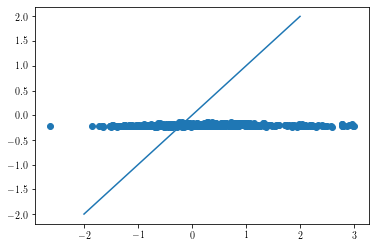

In [1153]:
prl = labeler(encoder(F1[:, ~homask].transpose(0,1))).detach().numpy()

i = 3
plt.scatter(labels[i, ~homask], prl[:, i])
plt.plot([-2,2], [-2,2])

''

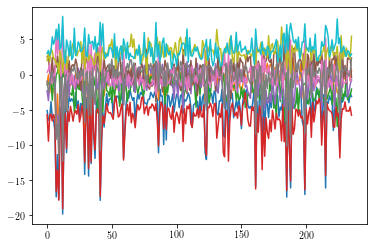

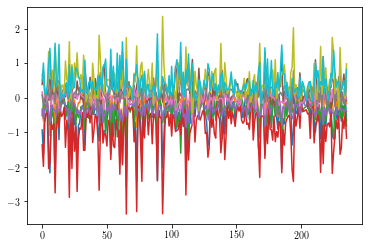

In [1095]:
z = encoder(pF1[homask, :])
plt.plot(z.detach().numpy())
plt.figure()
simz = encoder(torch.randn(pF1[homask, :].shape))
plt.plot(simz.detach().numpy())
;

<Figure size 864x432 with 0 Axes>

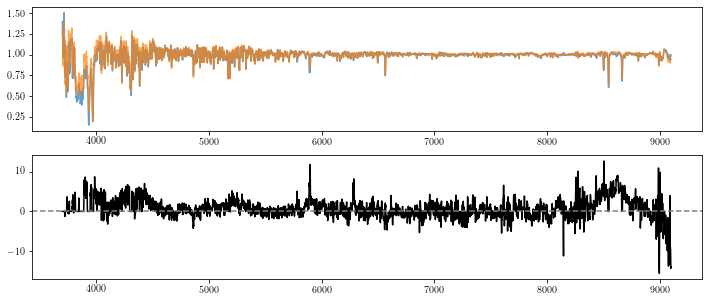

In [1096]:
j = 4
i = torch.where(homask)[0][j]

prF = (decoder(encoder(pF1[homask, :])).transpose(0,1)*sigmaF2 + muF2).detach().numpy()

plt.figure(figsize=(12, 6))
axs = plt.subplots(2, 1, figsize=(12, 5))[1]
plt.sca(axs[0])
obs = F2[:, homask][:, i].numpy()
inf = prF[:, i] 
plt.plot(lamost_wl, obs, alpha=0.7)
plt.plot(lamost_wl, inf, alpha=0.7)
#plt.xlim(5600,5700)
#plt.ylim(0.9,1.1)

plt.sca(axs[1])
plt.plot(lamost_wl, (inf-obs)/E2[:, homask][:, i].numpy(), c="k", zorder=0)
plt.axhline(0.0, ls="--", c="grey", zorder=1)
##plt.xlim(5600,5700)
##plt.ylim(-10, 10)

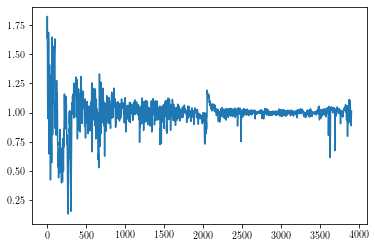

In [1381]:
plt.plot(F2[:, 2])

In [1304]:
homask

tensor([False, False, False,  ..., False, False,  True])